In [1]:
import os
import math

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

import cv2

from PIL import Image
# from skimage.io import imread
# from skimage.transform import resize
from glob import glob

import tensorflow as tf

from tensorflow import data
from tensorflow import image
from tensorflow.keras.preprocessing.image import random_rotation
from tensorflow.keras import layers, Input, Model
from tensorflow.keras import losses
from tensorflow.keras import optimizers
from tensorflow.keras.optimizers import Adam

In [2]:
import datasets
from datasets import load_dataset

### data load

In [3]:
dataset_train = load_dataset("nateraw/pascal-voc-2012", split='train', download_mode="reuse_cache_if_exists")

Using custom data configuration nateraw___pascal-voc-2012-c68607404d4811ac


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Dataset parquet downloaded and prepared to /aiffel/.cache/huggingface/datasets/parquet/nateraw___pascal-voc-2012-c68607404d4811ac/0.0.0/9296ce43568b20d72ff8ff8ecbc821a16b68e9b8b7058805ef11f06e035f911a. Subsequent calls will reuse this data.


In [4]:
import io
from PIL import Image
import numpy as np

def byte_to_rgb(byte_data):
    # Convert bytes to a PIL image
    buffer = io.BytesIO(byte_data)
    image = Image.open(buffer)

    # Ensure the image is in RGB format
    image_rgb = image.convert("RGB")

    # Convert the PIL image to a numpy array
    array_rgb = np.array(image_rgb)
    return array_rgb

In [5]:
data_train_image = [byte_to_rgb(data["image"]["bytes"]) for data in dataset_train]
data_train_mask = [byte_to_rgb(data["mask"]["bytes"]) for data in dataset_train]

### data check

In [6]:
import cv2
import matplotlib.pyplot as plt

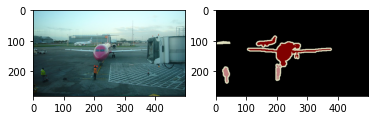

In [7]:
plt.subplot(1,2,1)
plt.imshow(data_train_image[0])
plt.subplot(1,2,2)
plt.imshow(data_train_mask[0])
plt.show()

In [8]:
import cv2
import numpy as np

def resize_image_opencv(image, target_shape=(256, 256)):
    return cv2.resize(image, target_shape[:2])

In [9]:
data_train_image_resize = [resize_image_opencv(img) for img in data_train_image]
data_train_mask_resize = [resize_image_opencv(img) for img in data_train_mask]

### numpy stack

In [10]:
data_train_image_stack = np.stack(data_train_image_resize)
data_train_mask_stack = np.stack(data_train_mask_resize)

In [11]:
data_train_image_stack.shape

(2913, 256, 256, 3)

In [12]:
data_train_mask_stack.shape

(2913, 256, 256, 3)

In [13]:
input_shape = data_train_image_stack[0].shape
input_shape

(256, 256, 3)

### normalize

In [14]:
import tensorflow as tf

def normalize(x):
    x = tf.cast(x, tf.float32)
    return (x/127.5) - 1

def denormalize(x):
    x = (x+1)*127.5
    x = x.numpy()
    return x.astype(np.uint8)

In [15]:
def make_batch(data, batch_size=4):
    dataset = tf.data.Dataset.from_tensor_slices(data)
    dataset = dataset.shuffle(buffer_size=3000)
    dataset = dataset.batch(batch_size)
    dataset = dataset.map(normalize, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
    return dataset

In [16]:
dataset_image = make_batch(data_train_image_stack)
dataset_mask = make_batch(data_train_mask_stack)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


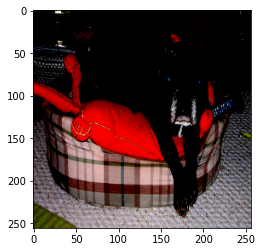

In [17]:
sample = dataset_image.take(1)
sample = list(sample.as_numpy_iterator())
plt.imshow(sample[0][0])

### augmentation

In [18]:
@tf.function() # 빠른 텐서플로 연산을 위해 @tf.function()을 사용합니다. 
def apply_augmentation(img):
#     _pad = tf.constant([[30,30],[30,30],[0,0]])
#     if tf.random.uniform(()) < .5:
#         padded = tf.pad(img, _pad, "REFLECT")
#     else:
#         padded = tf.pad(img, _pad, "CONSTANT", constant_values=1.)

    # 랜덤 이미지 왜곡
#     out = image.random_crop(padded, size=[256, 256, 3])
    out = image.random_flip_left_right(img)
    out = image.random_flip_up_down(out)
    
    # 50% 확률로 이미지 회전
    if tf.random.uniform(()) < .5:
        degree = tf.random.uniform([], minval=1, maxval=4, dtype=tf.int32)
        out = image.rot90(out, k=degree)
    
    return out[...,:3]

In [19]:
train_images = dataset_image.map(apply_augmentation).shuffle(100).batch(4)
mask_images = dataset_image.map(apply_augmentation).shuffle(100).batch(4)

### U-Net

In [20]:
from tensorflow import keras 
from tensorflow.keras import layers, models

In [21]:
class EncodeBlock(layers.Layer):
    def __init__(self, n_filters, use_bn=True):
        super(EncodeBlock, self).__init__()
        self.use_bn = use_bn       
        self.conv = layers.Conv2D(n_filters, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.lrelu = layers.LeakyReLU(0.2)

    def call(self, x):
        x = self.conv(x)
        if self.use_bn:
            x = self.batchnorm(x)
        return self.lrelu(x)

In [22]:
class DecodeBlock(layers.Layer):
    def __init__(self, f, dropout=True):
        super(DecodeBlock, self).__init__()
        self.dropout = dropout
        self.Transconv = layers.Conv2DTranspose(f, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.relu = layers.ReLU()
        
    def call(self, x):
        x = self.Transconv(x)
        x = self.batchnorm(x)
        if self.dropout:
            x = layers.Dropout(.5)(x)
        return self.relu(x)

In [23]:
class UNetGenerator(models.Model):
    def __init__(self):
        super(UNetGenerator, self).__init__()
        encode_filters = [64,128,256,512,512,512,512,512]
        decode_filters = [512,512,512,512,256,128,64]
        
        self.encode_blocks = []
        for i, f in enumerate(encode_filters):
            if i == 0:
                self.encode_blocks.append(EncodeBlock(f, use_bn=False))
            else:
                self.encode_blocks.append(EncodeBlock(f))
        
        self.decode_blocks = []
        for i, f in enumerate(decode_filters):
            if i < 3:
                self.decode_blocks.append(DecodeBlock(f))
            else:
                self.decode_blocks.append(DecodeBlock(f, dropout=False))
        
        self.last_conv = layers.Conv2DTranspose(3, 4, 2, "same", use_bias=False)
    
    def call(self, x):
        features = []
        for block in self.encode_blocks:
            x = block(x)
            features.append(x)
        
        features = features[:-1]
                    
        for block, feat in zip(self.decode_blocks, features[::-1]):
            x = block(x)
            x = layers.Concatenate()([x, feat])
        
        x = self.last_conv(x)
        return x
                
    def get_summary(self, input_shape=input_shape):
        inputs = layers.Input(input_shape)
        return models.Model(inputs, self.call(inputs)).summary()

In [24]:
UNetGenerator().get_summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
encode_block (EncodeBlock)      (None, 128, 128, 64) 3072        input_1[0][0]                    
__________________________________________________________________________________________________
encode_block_1 (EncodeBlock)    (None, 64, 64, 128)  131584      encode_block[0][0]               
__________________________________________________________________________________________________
encode_block_2 (EncodeBlock)    (None, 32, 32, 256)  525312      encode_block_1[0][0]             
______________________________________________________________________________________________

### discriminator

In [25]:
class DiscBlock(layers.Layer):
    def __init__(self, n_filters, stride=2, custom_pad=False, use_bn=True, act=True):
        super(DiscBlock, self).__init__()
        self.custom_pad = custom_pad
        self.use_bn = use_bn
        self.act = act
        
        if custom_pad:
            self.padding = layers.ZeroPadding2D()
            self.conv = layers.Conv2D(n_filters, 4, stride, "valid", use_bias=False)
        else:
            self.conv = layers.Conv2D(n_filters, 4, stride, "same", use_bias=False)
        
        self.batchnorm = layers.BatchNormalization() if use_bn else None
        self.lrelu = layers.LeakyReLU(0.2) if act else None
        
    def call(self, x):
        if self.custom_pad:
            x = self.padding(x)
            x = self.conv(x)
        else:
            x = self.conv(x)
                
        if self.use_bn:
            x = self.batchnorm(x)
            
        if self.act:
            x = self.lrelu(x)
        return x 

In [26]:
class Discriminator(models.Model):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.block1 = layers.Concatenate()
        self.blocks = [
            DiscBlock(n_filters=64, stride=2, custom_pad=False, use_bn=False, act=True),
            DiscBlock(n_filters=128, stride=2, custom_pad=False, use_bn=True, act=True),
            DiscBlock(n_filters=256, stride=2, custom_pad=False, use_bn=True, act=True),
            DiscBlock(n_filters=512, stride=1, custom_pad=True, use_bn=True, act=True),
            DiscBlock(n_filters=1, stride=1, custom_pad=True, use_bn=False, act=False)
        ]
        self.sigmoid = layers.Activation("sigmoid")
            
    def call(self, x, y):
        out = self.block1([x, y])
        for block in self.blocks:
            out = block(out)
        return self.sigmoid(out)
    
    def get_summary(self, x_shape=(256,256,3), y_shape=(256,256,3)):
        x, y = layers.Input(x_shape), layers.Input(y_shape) 
        return models.Model((x, y), self.call(x, y)).summary()


In [27]:
Discriminator().get_summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
concatenate_7 (Concatenate)     (None, 256, 256, 6)  0           input_2[0][0]                    
                                                                 input_3[0][0]                    
__________________________________________________________________________________________________
disc_block (DiscBlock)          (None, 128, 128, 64) 6144        concatenate_7[0][0]        

### train

In [28]:
bce = losses.BinaryCrossentropy(from_logits=False)
mae = losses.MeanAbsoluteError()

def get_gene_loss(fake_output, real_output, fake_disc):
    l1_loss = mae(real_output, fake_output)
    gene_loss = bce(tf.ones_like(fake_disc), fake_disc)
    return gene_loss, l1_loss

def get_disc_loss(fake_disc, real_disc):
    return bce(tf.zeros_like(fake_disc), fake_disc) + bce(tf.ones_like(real_disc), real_disc)

In [29]:
gene_opt = tf.keras.optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)
disc_opt = tf.keras.optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)

In [30]:
EPOCHS = 10

generator = UNetGenerator()
discriminator = Discriminator()
history = {'gen_loss':[], 'l1_loss':[], 'disc_loss':[]}
steps = len(dataset_image)

In [31]:
@tf.function
def train_step(sketch, real_colored):
    with tf.GradientTape() as gene_tape, tf.GradientTape() as disc_tape:
        # Generator 예측
        fake_colored = generator(sketch, training=True)
        # Discriminator 예측
        fake_disc = discriminator(sketch, fake_colored, training=True)
        real_disc = discriminator(sketch, real_colored, training=True)
        # Generator 손실 계산
        gene_loss, l1_loss = get_gene_loss(fake_colored, real_colored, fake_disc)
        gene_total_loss = gene_loss + (100 * l1_loss)
        # Discrminator 손실 계산
        disc_loss = get_disc_loss(fake_disc, real_disc)
                
    gene_gradient = gene_tape.gradient(gene_total_loss, generator.trainable_variables)
    disc_gradient = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    gene_opt.apply_gradients(zip(gene_gradient, generator.trainable_variables))
    disc_opt.apply_gradients(zip(disc_gradient, discriminator.trainable_variables))
    return gene_loss, l1_loss, disc_loss

In [ ]:
for epoch in range(1, EPOCHS+1):
    for i, (mask, image) in enumerate(zip(dataset_mask, dataset_image)):
        g_loss, l1_loss, d_loss = train_step(mask, image)
        history['gen_loss'].append(g_loss)
        history['l1_loss'].append(l1_loss)
        history['disc_loss'].append(d_loss)      
        
        # 진행률 표시
        elapsed = (i/steps) * 100
        if elapsed % 10 == 0:
            print('{:3}%'.format(int(elapsed)), end=' ')
            
        # 50회 반복마다 손실을 출력합니다.
        if (i+1) % steps == 0:
            print('\n\n')
            print(f"EPOCH[{epoch}] - STEP[{i+1}] \
                    \nGenerator_loss:{g_loss.numpy():.4f} \
                    \nL1_loss:{l1_loss.numpy():.4f} \
                    \nDiscriminator_loss:{d_loss.numpy():.4f}", end="\n\n")

  0% 